# Purpose:
- General stats of ROI matching between sessions and across training to check what kind of analysis can be done.
    - Both per plane and per volume


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scripts import roi_collection_across_sessions as rcas
from importlib import reload
from pystackreg import StackReg
import napari

base_dir = Path(r'E:\TPM\JK\h5')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]



In [52]:
mouse = 25
plane = 5

plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()
cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
roi_collection_results = np.load(cp_roi_collection_results_fn, allow_pickle=True).item()

registration_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
reg_result = np.load(registration_fn, allow_pickle=True).item()

session_nums = master_roi['session_nums']
assert len(session_nums) == len(roi_collection_results['matching_master_roi_index_list'])

matching_master_roi_ind = roi_collection_results['matching_master_roi_index_list']
master_map = master_roi['master_map_list'][-1]
viable_cell_index_list = master_roi['viable_cell_index_list'] # contains indices of cells in master_map
# (some got cut off due to boundary issue, etc.)

selected_session_num = np.asarray(reg_result['selected_session_num']) # some has list, some has array
# selected_session_num includes master_roi['session_nums'], but not all of them

roi_collection = np.zeros((master_map.shape[0], len(session_nums)), 'bool')
for si in range(len(session_nums)):
    session_num = session_nums[si]
    roi_dir = plane_dir / f'{session_num:03}' / 'plane0' / 'roi'
    iscell = np.load(roi_dir / 'iscell.npy')
    roi_inds = np.where(np.isin(viable_cell_index_list[si], np.where(iscell[:,0])[0]))[0]
    roi_collection[matching_master_roi_ind[si][roi_inds],si] = 1


In [37]:
np.where(iscell[:,0]==0)[0]

array([ 15,  24,  25,  26,  28,  31,  32,  33,  39,  40,  41,  44,  46,
        56,  63,  69,  76,  92,  94,  96,  98, 100, 103, 105, 106, 108,
       110, 111, 112, 113, 114], dtype=int64)

In [45]:
viewer = napari.Viewer()
si = 8
viewer.add_image(np.sum(master_map[np.where(roi_collection[:,si])[0]], axis=0))
viewer.add_image(np.sum(master_map[np.where(roi_collection[:,si+1])[0]], axis=0))
viewer.add_image(np.sum(master_map[np.where(roi_collection[:,si]*roi_collection[:,si+1])[0]], axis=0))

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'Image [2]' at 0x26420f4d760>

In [53]:
def plot_roi_collection(mouse, plane, base_dir):
    # Filter out dendrites
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
    master_roi = np.load(master_roi_fn, allow_pickle=True).item()
    cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
    roi_collection_results = np.load(cp_roi_collection_results_fn, allow_pickle=True).item()

    registration_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
    reg_result = np.load(registration_fn, allow_pickle=True).item()

    session_nums = master_roi['session_nums']
    assert len(session_nums) == len(roi_collection_results['matching_master_roi_index_list'])

    matching_master_roi_ind = roi_collection_results['matching_master_roi_index_list']
    master_map = master_roi['master_map_list'][-1]
    viable_cell_index_list = master_roi['viable_cell_index_list'] # contains indices of cells in master_map
    # (some got cut off due to boundary issue, etc.)

    selected_session_num = np.asarray(reg_result['selected_session_num']) # some has list, some has array
    # selected_session_num includes master_roi['session_nums'], but not all of them
    
    roi_collection = np.zeros((master_map.shape[0], len(session_nums)), 'bool')
    for si in range(len(session_nums)):
        session_num = session_nums[si]
        roi_dir = plane_dir / f'{session_num:03}' / 'plane0' / 'roi'
        iscell = np.load(roi_dir / 'iscell.npy')
        cell_inds = np.where(iscell[:,0])[0]
        roi_inds = np.where(np.isin(viable_cell_index_list[si], cell_inds))[0]
        roi_collection[matching_master_roi_ind[si][roi_inds],si] = 1
        
    roi_matching_mat = np.zeros((len(session_nums), len(session_nums)))
    for si in range(len(session_nums)):
        for sj in range(len(session_nums)):
            roi_matching_mat[si,sj] = np.sum(roi_collection[:,si] * roi_collection[:,sj], axis=0)

    reg_inds = [np.where(selected_session_num == sn)[0][0] for sn in session_nums]
    zdrift = [(np.min(reg_result['zdrift_list'][i]), np.max(reg_result['zdrift_list'][i])) for i in reg_inds]

    fig, ax = plt.subplots(1,3, figsize=(17,5))
    ax[0].plot(session_nums, np.sum(roi_collection, axis=0))
    ax[0].set_xlabel('Session number')
    ax[0].set_ylabel('# of ROIs')

    im = ax[1].imshow(roi_matching_mat, vmin=0, aspect='auto')
    plt.colorbar(im, label='# of matched ROIs', ax=ax[1])
    ax[1].set_xticks(np.arange(len(session_nums)))
    ax[1].set_yticks(np.arange(len(session_nums)))
    ax[1].set_xticklabels(session_nums)
    ax[1].set_yticklabels(session_nums)
    ax[1].set_xlabel('Session number')
    ax[1].set_ylabel('Session number')

    ax[2].plot(session_nums, np.array(zdrift)[:,0], 'k-')
    ax[2].plot(session_nums, np.array(zdrift)[:,1], 'k-')
    ax[2].fill_between(session_nums, np.array(zdrift)[:,0], np.array(zdrift)[:,1])
    ax[2].set_xlabel('Session number')
    ax[2].set_ylabel('Z drift')

    fig.suptitle(f'JK{mouse:03} plane {plane}')
    fig.tight_layout()
    return fig, ax

In [54]:
save_dir = Path(r'E:\TPM\JK\h5\qc\roi_matching')
mice = use_mice_df.mouse.unique()
planes = range(1,9)
for mouse in mice:
    for plane in planes:
        save_fn = save_dir / f'JK{mouse:03}_plane{plane}_roi_collection.png'
        # if not save_fn.exists():
        fig, ax = plot_roi_collection(mouse, plane, base_dir)
        fig.savefig(save_fn)
        plt.close(fig)

## distribution of matched ROIs across sessions
- Per plane

In [2]:
def roi_matching_to_master_map(mouse, plane, base_dir):
    # Filter out dendrites
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
    master_roi = np.load(master_roi_fn, allow_pickle=True).item()
    cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
    roi_collection_results = np.load(cp_roi_collection_results_fn, allow_pickle=True).item()

    session_nums = master_roi['session_nums']
    assert len(session_nums) == len(roi_collection_results['matching_master_roi_index_list'])

    matching_master_roi_ind = roi_collection_results['matching_master_roi_index_list']
    master_map = master_roi['master_map_list'][-1]
    viable_cell_index_list = master_roi['viable_cell_index_list'] # contains indices of cells in master_map
    # (some got cut off due to boundary issue, etc.)
   
    roi_collection = np.zeros((master_map.shape[0], len(session_nums)), 'bool')
    for si in range(len(session_nums)):
        session_num = session_nums[si]
        roi_dir = plane_dir / f'{session_num:03}' / 'plane0' / 'roi'
        iscell = np.load(roi_dir / 'iscell.npy')
        cell_inds = np.where(iscell[:,0])[0]
        roi_inds = np.where(np.isin(viable_cell_index_list[si], cell_inds))[0]
        roi_collection[matching_master_roi_ind[si][roi_inds],si] = 1
    return roi_collection

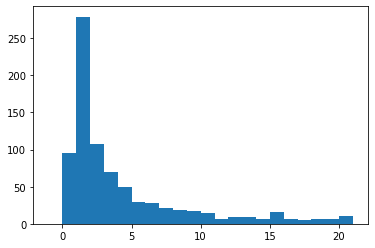

In [78]:
mouse = 39
plane = 1
roi_collection = roi_matching_to_master_map(mouse, plane, base_dir)
num_matched_sessions = np.sum(roi_collection, axis=1)
bins = range(-1,roi_collection.shape[1]+1)
plt.hist(num_matched_sessions, bins=bins);


# Volume-wise roi matching stats
- both session-to-session and across sessions

In [3]:
def roi_matching_volume_to_master_map(mouse, volume, base_dir):
    if volume == 1:
        planes = range(1,5)
    elif volume == 2:
        planes = range(5,9)
    else:
        raise ValueError('Volume should be 1 or 2')
    for i in range(len(planes)):
        plane = planes[i]
        if i == 0:
            roi_collection = roi_matching_to_master_map(mouse, plane, base_dir)
        else:
            roi_collection = np.vstack((roi_collection, roi_matching_to_master_map(mouse, plane, base_dir)))
    return roi_collection

Text(0.5, 0.98, 'JK036 volume 1')

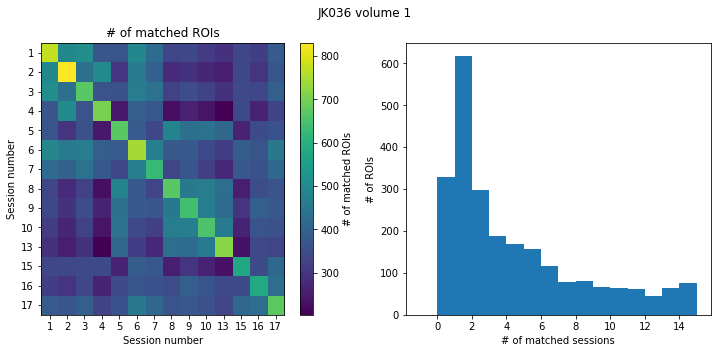

In [47]:
mouse = 36
volume = 1
roi_collection = roi_matching_volume_to_master_map(mouse, volume, base_dir)
plane = (volume-1)*4 + 1
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()
session_nums = master_roi['session_nums']

registration_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
reg_result = np.load(registration_fn, allow_pickle=True).item()
selected_session_num = np.asarray(reg_result['selected_session_num'])

roi_matching_mat = np.zeros((len(session_nums), len(session_nums)))
for si in range(len(session_nums)):
    for sj in range(len(session_nums)):
        roi_matching_mat[si,sj] = np.sum(roi_collection[:,si] * roi_collection[:,sj], axis=0)
reg_inds = [np.where(selected_session_num == sn)[0][0] for sn in session_nums]
fig, ax = plt.subplots(1,2,figsize=(12,5))
im = ax[0].imshow(roi_matching_mat, vmin=np.min(roi_matching_mat), aspect='auto')
plt.colorbar(im, label='# of matched ROIs', ax=ax[0])
ax[0].axis('equal')
ax[0].axis('tight')
ax[0].set_xticks(np.arange(len(session_nums)))
ax[0].set_yticks(np.arange(len(session_nums)))
ax[0].set_xticklabels(session_nums)
ax[0].set_yticklabels(session_nums)
ax[0].set_xlabel('Session number')
ax[0].set_ylabel('Session number')
ax[0].set_title('# of matched ROIs')

num_matched_sessions = np.sum(roi_collection, axis=1)
bins = range(-1,roi_collection.shape[1]+2)
ax[1].hist(num_matched_sessions, bins=bins);
ax[1].set_xlabel('# of matched sessions')
ax[1].set_ylabel('# of ROIs')

fig.suptitle(f'JK{mouse:03} volume {volume}')

In [44]:
def plot_roi_matching_volume(mouse, volume, base_dir, session_nums=None):
    roi_collection = roi_matching_volume_to_master_map(mouse, volume, base_dir)
    plane = (volume-1)*4 + 1
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
    master_roi = np.load(master_roi_fn, allow_pickle=True).item()
    if session_nums is None:
        session_nums = master_roi['session_nums']
    else:
        session_nums = np.asarray(session_nums)
        assert np.all(np.isin(session_nums, master_roi['session_nums']))
        session_inds = [np.where(master_roi['session_nums'] == sn)[0][0] for sn in session_nums]
        roi_collection = roi_collection[:,session_inds]

    roi_matching_mat = np.zeros((len(session_nums), len(session_nums)))
    for si in range(len(session_nums)):
        for sj in range(len(session_nums)):
            roi_matching_mat[si,sj] = np.sum(roi_collection[:,si] * roi_collection[:,sj], axis=0)
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    im = ax[0].imshow(roi_matching_mat, vmin=np.min(roi_matching_mat), aspect='auto')
    plt.colorbar(im, label='# of matched ROIs', ax=ax[0])
    ax[0].axis('equal')
    ax[0].axis('tight')
    ax[0].set_xticks(np.arange(len(session_nums)))
    ax[0].set_yticks(np.arange(len(session_nums)))
    ax[0].set_xticklabels(session_nums)
    ax[0].set_yticklabels(session_nums)
    ax[0].set_xlabel('Session number')
    ax[0].set_ylabel('Session number')
    ax[0].set_title('# of matched ROIs')

    num_matched_sessions = np.sum(roi_collection, axis=1)
    bins = range(-1,roi_collection.shape[1]+2)
    ax[1].hist(num_matched_sessions, bins=bins);
    ax[1].set_xlabel('# of matched sessions')
    ax[1].set_ylabel('# of ROIs')

    fig.suptitle(f'JK{mouse:03} volume {volume}')

    return fig, ax

In [45]:
save_dir = Path(r'E:\TPM\JK\h5\stats\roi_matching')
save_dir.mkdir(parents=True, exist_ok=True)
mice = use_mice_df.mouse.unique()
for mouse in mice:
    for volume in range(1,3):
        save_fn = save_dir / f'JK{mouse:03}_volume{volume}_roi_matching.png'
        # if not save_fn.exists():
        fig, ax = plot_roi_matching_volume(mouse, volume, base_dir)
        fig.savefig(save_fn)
        plt.close(fig)

## Limiting to training sessions only

In [8]:
use_mice_df

,Unnamed: 0.1,mouse,plane,session,session_type,depth_matched,processing_error,remove_frame_ind
0,0,25,1,1,training,True,False,0
1,1,25,1,2,training,True,False,0
2,2,25,1,3,training,True,False,0
3,3,25,1,4,test_naive,True,False,0
4,4,25,1,5,training,True,False,0
...,...,...,...,...,...,...,...,...
1452,1452,52,8,16,training,True,False,0
1453,1453,52,8,17,training,True,False,[ 0 109]
1454,1454,52,8,18,training,True,False,0
1456,1456,52,8,20,training,True,False,0


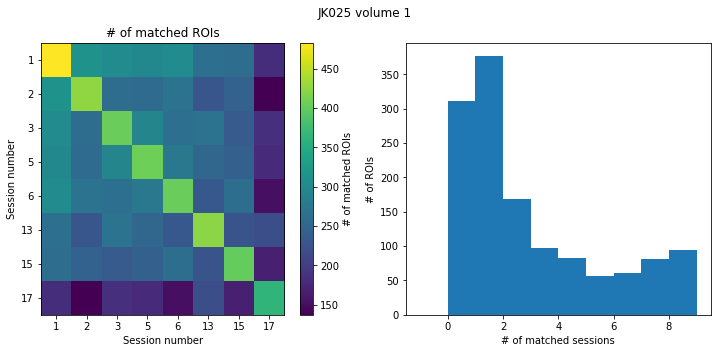

In [48]:
mouse = 25
volume = 1
top_plane = (volume-1)*4 + 1
training_sessions = use_mice_df.query('mouse == @mouse and plane==@top_plane and \
                                      session_type == "training" and depth_matched == True \
                                      and processing_error == False').session.unique()
training_sessions = np.array([int(s) for s in training_sessions])
fig, ax = plot_roi_matching_volume(mouse, volume, base_dir, training_sessions)

In [49]:
save_dir = Path(r'E:\TPM\JK\h5\stats\roi_matching')
save_dir.mkdir(parents=True, exist_ok=True)
mice = use_mice_df.mouse.unique()
for mouse in mice:
    for volume in range(1,3):
        save_fn = save_dir / f'JK{mouse:03}_volume{volume}_roi_matching_training.png'
        # if not save_fn.exists():
        top_plane = (volume-1)*4 + 1
        training_sessions = use_mice_df.query('mouse == @mouse and plane==@top_plane and \
                                            session_type == "training" and depth_matched == True \
                                            and processing_error == False').session.unique()
        training_sessions = np.array([int(s) for s in training_sessions])
        fig, ax = plot_roi_matching_volume(mouse, volume, base_dir, training_sessions)
        fig.savefig(save_fn)
        plt.close(fig)

## Check the calculation
- somehow the matrix and histogram does not seem to match

In [16]:
mouse = 25
volume = 1
roi_collection = roi_matching_volume_to_master_map(mouse, volume, base_dir)

top_plane = (volume-1)*4 + 1
training_sessions = use_mice_df.query('mouse == @mouse and plane==@top_plane and \
                                    session_type == "training" and depth_matched == True \
                                    and processing_error == False').session.unique()
training_sessions = np.array([int(s) for s in training_sessions])

plane_dir = base_dir / f'{mouse:03}' / f'plane_{top_plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{top_plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()

session_inds = [np.where(master_roi['session_nums'] == sn)[0][0] for sn in training_sessions]
roi_collection = roi_collection[:,session_inds]


In [22]:
num_appear = np.sum(roi_collection, axis=1)
len(np.where(num_appear == len(training_sessions))[0])

94

In [43]:
bins = range(-1,roi_collection.shape[1]+2)
np.histogram(num_appear, bins=bins)[0]

array([  0, 311, 377, 169,  98,  83,  57,  61,  81,  94], dtype=int64)

## Some numbers
- Num ROI matched for all sessions, all-1, all-2. Average and per mouse.
- Between pairs. Look at if that changes across sessions (JK052 expected to increase).


## Do this after filtering pairs to compare